In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
titanic_data = pd.read_csv('train.csv')

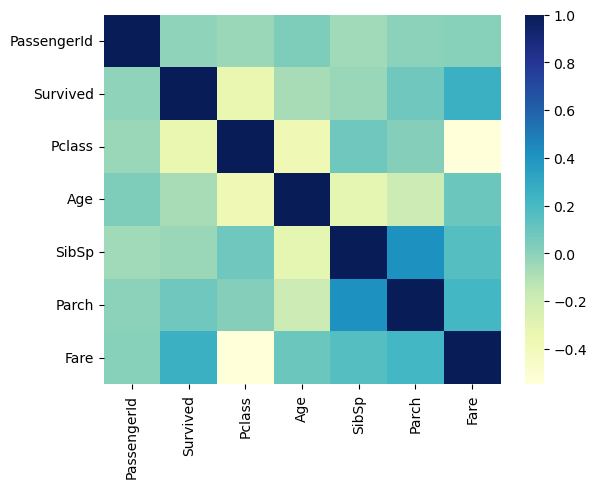

In [3]:
import seaborn as sns
sns.heatmap(titanic_data.corr(), cmap = 'YlGnBu')
plt.show()

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

In [5]:
sns.pairplot(titanic_data, hue='Survived')

In [6]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy = "mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X


In [8]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
            
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        
            
        return X


In [9]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder())])


In [10]:
strat_train_set = pipeline.fit_transform(strat_train_set)

IndexError: list index out of range

In [11]:
strat_train_set = strat_train_set.drop(['Cabin', 'PassengerId', 'Name', 'Ticket','Sex','Embarked'], axis = 1)

In [12]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring = "accuracy", return_train_score = True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [14]:
final_clf = grid_search.best_estimator_

In [15]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=500)

In [16]:
strat_test_set = pipeline.fit_transform(strat_test_set)
strat_test_set = strat_test_set.drop(['Cabin', 'PassengerId', 'Name', 'Ticket','Sex','Embarked'], axis = 1)

In [17]:
X_test = strat_test_set.drop(['Survived'], axis = 1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [18]:
final_clf.score(X_data_test, y_data_test)

0.8156424581005587

In [19]:
final_data = titanic_data
final_data = pipeline.fit_transform(final_data)

IndexError: list index out of range

In [20]:
final_data = final_data.drop(['Cabin', 'PassengerId', 'Name', 'Ticket','Sex','Embarked'], axis = 1)

In [21]:
final_data

Survived  Pclass        Age  SibSp  Parch     Fare  Female  Male    C  \
0           0       3  22.000000      1      0   7.2500     0.0   1.0  0.0   
1           1       1  38.000000      1      0  71.2833     1.0   0.0  1.0   
2           1       3  26.000000      0      0   7.9250     1.0   0.0  0.0   
3           1       1  35.000000      1      0  53.1000     1.0   0.0  0.0   
4           0       3  35.000000      0      0   8.0500     0.0   1.0  0.0   
..        ...     ...        ...    ...    ...      ...     ...   ...  ...   
886         0       2  27.000000      0      0  13.0000     0.0   1.0  0.0   
887         1       1  19.000000      0      0  30.0000     1.0   0.0  0.0   
888         0       3  29.699118      1      2  23.4500     1.0   0.0  0.0   
889         1       1  26.000000      0      0  30.0000     0.0   1.0  1.0   
890         0       3  32.000000      0      0   7.7500     0.0   1.0  0.0   

       S    Q  
0    0.0  1.0  
1    0.0  0.0  
2    0.0  1.0  
3    0.0  1.0  
4    0.0  1.0  
..   ...  ...  
886  0.0  1.0  
887  0.0  1.0  
888  0.0  1.0  
889  0.0  0.0  
890  1.0  0.0  

[891 rows x 11 columns]

In [22]:
X_final = final_data.drop(['Survived'], axis = 1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [23]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv = 3, scoring = "accuracy", return_train_score = True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [24]:
prod_final_clf = grid_search.best_estimator_

In [25]:
titanic_test_data = pd.read_csv('test.csv')

In [26]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [27]:
final_test_data = final_test_data.drop(['Cabin', 'PassengerId', 'Name', 'Ticket','Sex','Embarked'], axis = 1)

In [28]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method = 'ffill')

scaler = StandardScaler()

X_data_final_test = scaler.fit_transform(X_final_test)

In [29]:
predictions = prod_final_clf.predict(X_data_final_test)

In [30]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index = False)

In [31]:
final_df

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

In [32]:
from sklearn.metrics import confusion_matrix

df_true = pd.read_csv('gender_submission.csv')

y_true = df_true['Survived']
y_pred = final_df['Survived']

conf_matrix = confusion_matrix(y_true, y_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Positive', 'True Negative'], columns=['Predicted Positive', 'Predicted Negative'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

In [33]:
path = 'C:/Users/dela/Desktop/Projet Data Titanic/model2.pkl'

import pickle

with open(path, 'wb') as fichier:
    pickle.dump(final_clf, fichier)